# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Перед нами стоит задача: определить рыночную стоимость объектов недвижимости. Для этого проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Общая информация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [2]:
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

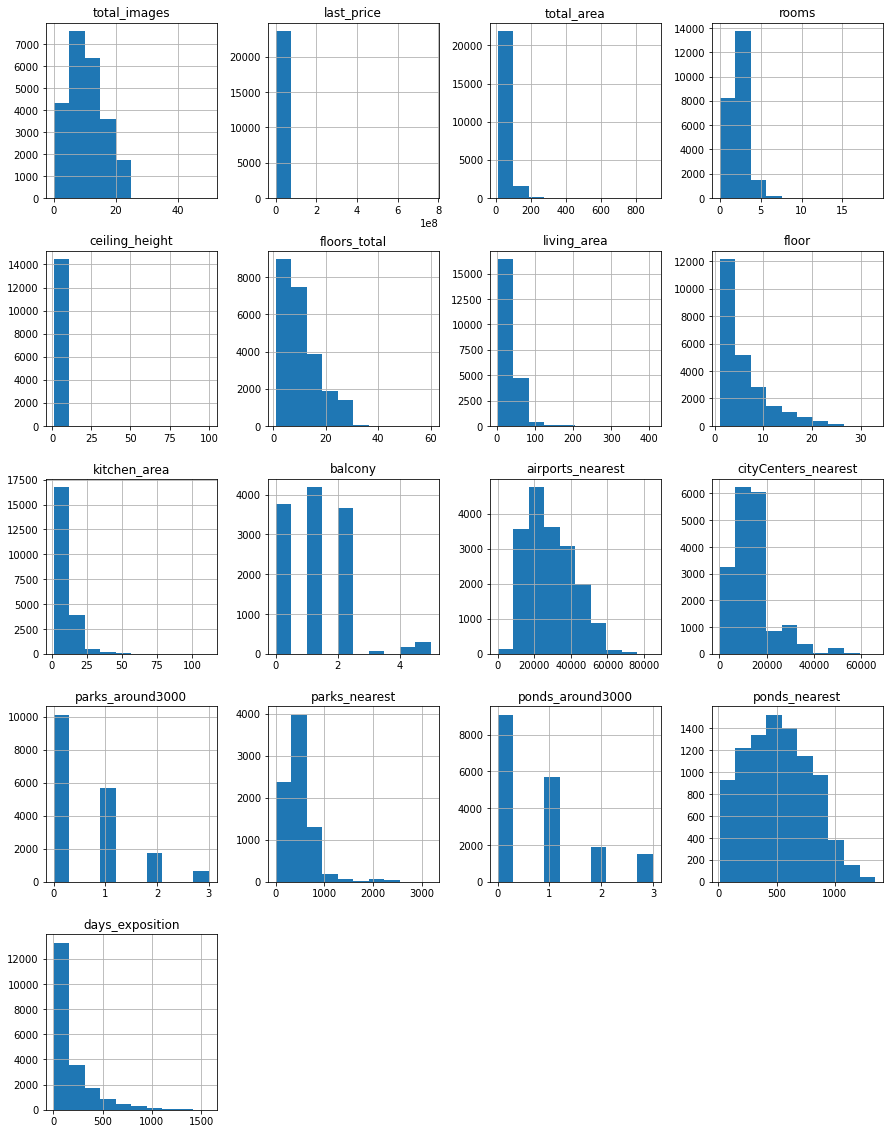

In [4]:
data.drop_duplicates()
data.hist(figsize=(15, 20));

**Вывод**

В датасете 23699 поля и 22 колонки. В 2/3 части данных обнаружены пропуски, которые предстоит обработать. По получившимся гистограмамм можно обнаружить наличие редких и аномальных значений

### Предобработка данных

#### Удаление пропусков

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Рассмотрим столбец "ceiling_height", содержащий в себе информацию о высоте потолков. Данная характеристика помещения фактически является независимой, поэтому пропуски в столбце заполним медианным значением   

In [6]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

Значения столбца "floors_total" непосредственно связаны со значениями "floor", а, точнее, номер этажа не может превосходить общее число этажей в доме, соостветсвенно, производить заполнение медианным значением нецелесообразно. Заметим, что в "floors_total" насчитывается 86 пропусков, что составляет всего лишь 0.36% от общего объема данных столбца, это доля незначительна, следовательно, можно оставить столбец без измененийи не заполнять пропуски, дабы не усугубить ситуацию 

В "living_area" обнаружено 1903 пропуска. Выдвинем и проверим следующую гипотезу:
- жилая площадь зависит от числа комнат и общей площади.

Если гипотеза подтвердится, рассчитаем медианные значения жилой площади в зависимости от числа комнат и заполним получившимися числами пропуски в столбце, характеризующем жилую площадь

In [7]:
data.corr()['living_area']

total_images           0.104780
last_price             0.566492
total_area             0.939537
rooms                  0.845977
ceiling_height         0.078623
floors_total          -0.169311
living_area            1.000000
floor                 -0.097210
studio                -0.056231
open_plan             -0.033711
kitchen_area           0.428674
balcony                0.018849
airports_nearest      -0.057912
cityCenters_nearest   -0.231368
parks_around3000       0.184453
parks_nearest         -0.050167
ponds_around3000       0.148933
ponds_nearest         -0.081674
days_exposition        0.142454
Name: living_area, dtype: float64

In [8]:
#Функция, рассчитывающая медианные значения в зависимости от передаваемых параметров для обработки пропусков
def replacing_median(column, index):
    try:
        median_data = data.pivot_table(index=index, values=column, aggfunc='median')
        new_column = data[column].fillna(data[index].map(median_data[column]))
        return new_column
    except:
        pass

Да, действительно, жилая площадь зависит от общей площади и числа комнат. Построим таблицу, в которой определим медианное значение жилой площади в зависимости от количества комнат

In [9]:
data['living_area'] = replacing_median('living_area', 'rooms')

Жилая площадь не должна превосходить общую площадь. Найдем и исправим такие ситуации

In [10]:
data.loc[data['living_area'] > data['total_area'], 'living_area'] = float('nan')

In [11]:
data['living_area'].isna().sum()

29

Число пропущенных значений сократилось с 1903 до 29. 29 - это 0,12% от общего объема данных, представленных в столбце

В столбце "is_apartment" 20924 пропуска. Данные являются катгориальными, поэтому можно сказать, что наличие пропусков означает, что данное помещение не является апартаментами

In [12]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Заменим "NaN" на False:

In [13]:
data['is_apartment'] = data['is_apartment'].fillna(False)

В столбце "kitchen_area" выявлено 2278 пропусков. Проведем исследование их природы

Поскольку в наших данных присутствуют квартиры-студии, обратим внимание на них и исследуем их особенности

In [14]:
data[data['studio'] == True].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30T00:00:00,0,2.65,24.0,15.50,2,False,True,False,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,2.65,17.0,24.75,4,False,True,False,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
608,2,1850000.0,25.00,2019-02-20T00:00:00,0,2.65,10.0,18.00,7,False,True,False,NaN,NaN,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0
697,12,2500000.0,24.10,2017-12-01T00:00:00,0,2.75,25.0,17.50,21,False,True,False,NaN,NaN,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,201.0
716,5,1500000.0,17.00,2017-06-07T00:00:00,0,2.70,9.0,12.00,1,False,True,False,NaN,0.0,посёлок Шушары,18654.0,29846.0,0.0,NaN,0.0,NaN,40.0
1173,12,3240000.0,29.00,2018-10-30T00:00:00,0,2.65,24.0,17.00,2,False,True,False,NaN,2.0,Санкт-Петербург,35129.0,16293.0,0.0,NaN,1.0,475.0,13.0
1174,3,3900000.0,32.00,2016-10-18T00:00:00,0,2.70,24.0,18.00,2,False,True,False,NaN,2.0,Санкт-Петербург,44754.0,8409.0,1.0,609.0,0.0,NaN,540.0
1220,5,3300000.0,27.00,2017-11-10T00:00:00,0,2.80,17.0,20.00,16,False,True,False,NaN,NaN,Санкт-Петербург,12507.0,12419.0,0.0,NaN,1.0,528.0,113.0
1260,0,2600000.0,27.00,2018-07-20T00:00:00,0,2.70,16.0,16.00,4,False,True,False,NaN,2.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,102.0
1277,10,3150000.0,26.00,2017-07-14T00:00:00,0,2.75,21.0,17.38,11,False,True,False,NaN,NaN,Санкт-Петербург,48847.0,16685.0,0.0,NaN,0.0,NaN,622.0


Число комнат в квартирах студиях равняется нулю, следовательно, кухня не считается комнатой. Для таких случаев будет справедливо, если мы заменим пропуски нулями.

In [15]:
data.loc[(data['kitchen_area'].isna()) & (data['studio']), 'kitchen_area'] = 0

В остальных случаях рассчитаем медианные значения площади кухни в зависимости от числа комнат. Важно учитывать, что кухня не является жилым помещением, следовательно, замену будем осуществлять только для полей, удовлетворяющих условию: 
- площадь кухни < общая площадь - жилая площадь

In [16]:
data['kitchen_area'] = replacing_median('kitchen_area', 'rooms')

In [17]:
data.loc[data['total_area'] - data['living_area'] < data['kitchen_area'], 'kitchen_area'] = float('nan')

Столбец "balcony" характеризует наличие балкона(ов) в квартире. Пропуски в данных могут быть связаны с отсутсвием балконов в квартире. Пусть 0 означает отсуствие балконов для данного столбца

In [18]:
data['balcony'] = data['balcony'].fillna(0) 

В "locality_name" обнаружено всего лишь 49 пропусков 

In [19]:
data['locality_name'] = data['locality_name'].fillna('Другое')

parks_around3000 и ponds_around3000 - столбцы, характеризующие число парков и водоемов в радиусе 3000м соответственно (c одинаковым количеством пропусков). Пропуски в данных столбцах означают отсутсвие парков и водоемов, поэтому заполним их нулями.

In [20]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

Пропуски в days_exposition могли появиться по следующим причинам: объявление о продаже снято в день публикации, поэтому между датой размещения и датой завершения продажи прошло 0 дней или на момент выгрузки данных объявления могли быть активными, поэтому число дней осталось незафиксированным. Пропуски в данном случае заполнять не будем

#### Для корректного заполнения пропусков необходимо избавиться от дубликатов

In [21]:
data['locality_name'].nunique()

365

Проведем предварительную подготовку данных

In [22]:
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.strip()
data['locality_name'] = data['locality_name'].str.replace('  ', ' ', regex=False)

In [23]:
sorted(data['locality_name'].unique())

['бокситогорск',
 'волосово',
 'волхов',
 'всеволожск',
 'выборг',
 'высоцк',
 'гатчина',
 'городской поселок большая ижора',
 'городской поселок будогощь',
 'городской поселок виллози',
 'городской поселок лесогорский',
 'городской поселок мга',
 'городской поселок назия',
 'городской поселок новоселье',
 'городской поселок павлово',
 'городской поселок рощино',
 'городской поселок свирьстрой',
 'городской поселок советский',
 'городской поселок федоровское',
 'городской поселок янино-1',
 'деревня агалатово',
 'деревня аро',
 'деревня батово',
 'деревня бегуницы',
 'деревня белогорка',
 'деревня большая вруда',
 'деревня большая пустомержа',
 'деревня большие колпаны',
 'деревня большое рейзино',
 'деревня большой сабск',
 'деревня бор',
 'деревня борисова грива',
 'деревня ваганово',
 'деревня вартемяги',
 'деревня вахнова кара',
 'деревня выскатка',
 'деревня гарболово',
 'деревня глинка',
 'деревня горбунки',
 'деревня гостилицы',
 'деревня заклинье',
 'деревня заневка',
 'деревня

Удалим все вхождения слов, не несущих смысловой нагрузки

In [24]:
strings_to_remove = ['городской', 'городского типа', 'коттеджный', 'садоводческое некоммерческое', 'садовое',] 

data['locality_name'] = data['locality_name'].replace('|'.join(strings_to_remove), '', regex=True).str.strip()
data['locality_name'] = data['locality_name'].str.strip().str.replace('  ', ' ')

In [25]:
sorted(data['locality_name'].unique())

['бокситогорск',
 'волосово',
 'волхов',
 'всеволожск',
 'выборг',
 'высоцк',
 'гатчина',
 'деревня агалатово',
 'деревня аро',
 'деревня батово',
 'деревня бегуницы',
 'деревня белогорка',
 'деревня большая вруда',
 'деревня большая пустомержа',
 'деревня большие колпаны',
 'деревня большое рейзино',
 'деревня большой сабск',
 'деревня бор',
 'деревня борисова грива',
 'деревня ваганово',
 'деревня вартемяги',
 'деревня вахнова кара',
 'деревня выскатка',
 'деревня гарболово',
 'деревня глинка',
 'деревня горбунки',
 'деревня гостилицы',
 'деревня заклинье',
 'деревня заневка',
 'деревня зимитицы',
 'деревня извара',
 'деревня иссад',
 'деревня калитино',
 'деревня кальтино',
 'деревня камышовка',
 'деревня каськово',
 'деревня келози',
 'деревня кипень',
 'деревня кисельня',
 'деревня колтуши',
 'деревня коркино',
 'деревня котлы',
 'деревня кривко',
 'деревня кудрово',
 'деревня кузьмолово',
 'деревня курковицы',
 'деревня куровицы',
 'деревня куттузи',
 'деревня лаврики',
 'деревня

In [26]:
data['locality_name'].nunique()

322

**Вывод**

В результате обработки неявных дубликатов удалось сократить число исследуемых населенных пунктов с 365 до 322, то есть в изначальном списке насчитывалось 43 дубликата

#### Вернемся к заполнению пропусков

Рассмотрим группу столбцов, характеризующую расстояние от квартиры до того или иного объекта инфраструктуры:
* airports_nearest         
* cityCenters_nearest      
* parks_nearest        
* ponds_nearest          


Замена в стошлбцах parks_nearest, ponds_nearest не производится, так как получится следующее искажение данных:
медианное значение для населенного пункта может не превосходить 3000м, тогда, если значение в столбцах ponds_around3000 и parks_around3000 равно 0, получается несоответствие. Значения в parks_nearest и ponds_nearest должны превосходить 3000м и одновремнно с этим в around3000 должны быть нули

Картографические данные не восстановить с достаточной точностью, поэтому оставим их без изменений

**Вывод**

В результате обработки пропусков полностью удалось избавиться от пропусков в столбцах с категориальными значениями и столбцах, в которых можно однозначно определить медианное значение параметра. Часть пропусков не удалось обработать по следующим причинам:
1. Отсуствие возможности подобрать значение, наиболее верно отражающее истинный смысл NaN и не нарушающее целостности типа данных столбца
2. Влияние на параметры, зависящие от исследуемого столбца, порождающее несоответсвие между данными

#### Типы данных в каждом столбце

In [27]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

In [28]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,False,False,False,11.0,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,False,False,False,8.3,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,45.0,9,False,False,False,9.5,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,False,False,41.0,0.0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


* first_day_exposition - данные в этом столбце следует привести к типу Date для корректного отображения информации в датафрейме и возможности проведения дальнейшего исследования
* floors_total, balcony, parks_around3000, ponds_around3000 - представляют целочисленные значения. Например, число этажей в доме не может быть представлено в виде дробного. Для смыслового соответсвия преобразуем float в int 
* столбцы с типом данных float64 заменим на float32 для экономии памяти

In [29]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

floors_total привести к целочисленному не получится, так как в этих столбцах присутствует значение NaN

In [30]:
convert_dic = {
               'balcony': int, 
               'parks_around3000': int,
               'ponds_around3000': int,  
               'days_exposition': np.float32,
               'last_price': np.float32,
               'total_area': np.float32, 
               'ceiling_height': np.float32, 
               'floors_total': np.float32,
               'living_area': np.float32,
               'kitchen_area': np.float32, 
               'airports_nearest': np.float32, 
               'cityCenters_nearest': np.float32,
               'parks_nearest': np.float32, 
               'ponds_nearest': np.float32
              }

data = data.astype(convert_dic)

### Расширение датафрейма

#### Цена одного квадратного метра

In [31]:
data['price_metr'] = (data['last_price'] / data['total_area']).round(2)

#### День недели публикации объявления

In [32]:
data['day_of_pub'] = data['first_day_exposition'].dt.weekday

#### Месяц публикации объявления

In [33]:
data['month_of_pub'] =  data['first_day_exposition'].dt.month

#### Год публикации объявления

In [34]:
data['year_of_pub'] =  data['first_day_exposition'].dt.year

#### Тип этажа квартиры

In [35]:
def categorize_floor(floor, floors_total):
    try:
        if floor == 1:
            return 'первый'
        if floor == floors_total:
            return 'последний'
        else:
            return 'другой'
    except:
        pass

In [36]:
data['categorize_floor'] = (data[~data['floors_total'].isna()]
                            .apply(lambda row: categorize_floor(row['floor'], row['floors_total']), axis=1)
                           )

Обработаем вручную случаи, длякоторых значение floors_total неизвестны

In [37]:
data.loc[(data['floors_total'].isna()) & (data['floor'] == 1), 'categorize_floor'] = 'первый'
data.loc[(data['floors_total'].isna()) & (data['floor'] != 1), 'categorize_floor'] = 'другой'

#### Расстояние до центра города в километрах

In [38]:
data['cityCenters_km'] = np.where(data['cityCenters_nearest'].isna(), np.nan, (data['cityCenters_nearest'] / 1000).round(2))

### Исследовательский анализ данных

#### Обработка аномальных значений

В рамках этого раздела проведем исследование следующих параметров:
* общая площадь - total_area
* жилая площадь - living_area
* площадь кухни - kitchen_area
* цена объекта - last_price
* количество комнат - rooms
* высота потолков - ceiling_height
* тип этажа квартиры - categorize_floor
* общее количество этажей в доме - floors_total
* расстояние до центра города в метрах - cityCenters_nearest
* расстояние до ближайшего парка - parks_nearest

array([[<AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'kitchen_area'}>],
       [<AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'ceiling_height'}>],
       [<AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>]], dtype=object)

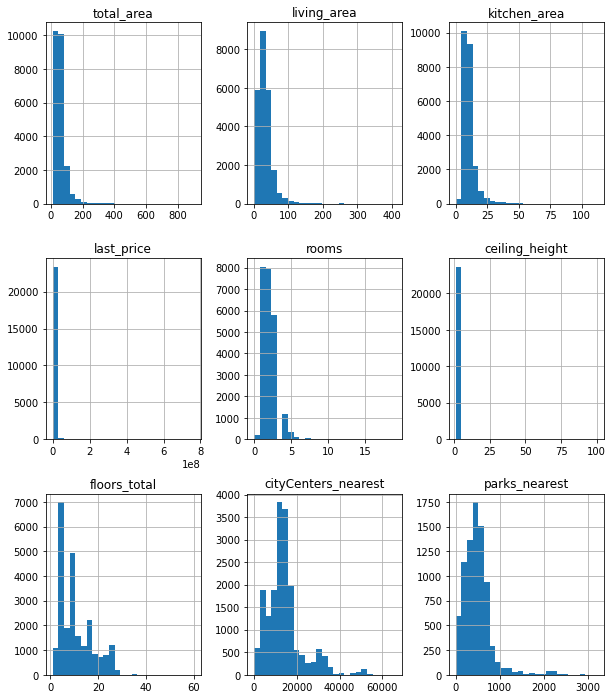

In [39]:
columns = ['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height',
           'floors_total', 'cityCenters_nearest', 'parks_nearest']
data[columns].hist(figsize=(10, 12), bins=25)

Реже всего встречается общая площадь от 210 до 400 метров квадратных, а наиболее редкий метраж у жилой площади составляет 160 - 210 метров квадратных, удалим эти значения из датасета

In [40]:
data = data[data['total_area'] < 210]
data = data[data['living_area'] < 160]

Площадь кухни в большинстве случаев не превышает 36 метров квадратных

In [41]:
data = data[data['kitchen_area'] < 30]

В редких случаях цена объекта может быть ниже 100 000 рублей

In [42]:
data = data[data['last_price'] > 100000]

В среднем в квартире насчитывается от 1-й до 3-х комнат, квартиры, число комнат в которых больше 5, скорее, являются исключением из правил

In [43]:
data = data[data['rooms'] < 6]

Отдельно рассмотрим высоту потолков

In [44]:
data['ceiling_height'].describe()

count    22809.000000
mean         2.714992
std          0.976748
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [45]:
data[data['ceiling_height'] > 3 ].sort_values(by='ceiling_height', ascending=False).head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metr,day_of_pub,month_of_pub,year_of_pub,categorize_floor,cityCenters_km
22869,0,15000000.0,25.000000,2018-07-25,1,100.0,5.0,14.0,5,True,False,False,11.0,5,санкт-петербург,34963.0,8283.0,1,223.0,3,30.0,19.0,600000.000000,2,7,2018,последний,8.28
22336,19,9999000.0,92.400002,2019-04-05,2,32.0,6.0,55.5,5,False,False,False,16.5,4,санкт-петербург,18838.0,3506.0,0,NaN,3,511.0,NaN,108214.281250,4,4,2019,другой,3.51
3148,14,2900000.0,75.000000,2018-11-12,3,32.0,3.0,53.0,2,False,False,False,8.0,0,волхов,NaN,NaN,0,NaN,0,NaN,NaN,38666.671875,0,11,2018,другой,NaN
17857,1,3900000.0,56.000000,2017-12-22,3,27.0,5.0,33.0,4,False,False,False,9.5,0,санкт-петербург,41030.0,15543.0,0,NaN,0,NaN,73.0,69642.859375,4,12,2017,другой,15.54
10773,8,3800000.0,58.000000,2017-10-13,2,27.0,10.0,30.1,3,False,False,False,8.1,2,поселок мурино,NaN,NaN,0,NaN,0,NaN,71.0,65517.238281,4,10,2017,другой,NaN


В датафрейме встречаются значения высот, которые превышают 10м и, к тому же, являются двузначными числами. Очевидно, в таких ячейках потеряна точка для вещественного значения

In [46]:
mask = data['ceiling_height'] > 10
data.loc[mask, 'ceiling_height'] = data.loc[mask, 'ceiling_height'] / 10

<AxesSubplot:>

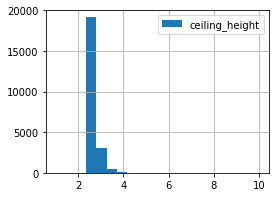

In [47]:
data['ceiling_height'].hist(bins=20, figsize=(4, 3), legend=True)

Гистограмма распределения высот потолков служит подтверждением того, что меньше всего насчитывается потолков высотой более 4-x метров

In [48]:
data = data[data['ceiling_height'] < 5]

В редких случаях этажность дома составляет 30 этажей и более

In [49]:
data = data[data['floors_total'] <= 30 ]

Чаще всего расстояние от объекта недвижимости до центра города не превышает 60км, а расстояние от квартиры до ближайшего парка лежит в пределах 2,8км

array([[<AxesSubplot:title={'center':'cityCenters_nearest'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>]], dtype=object)

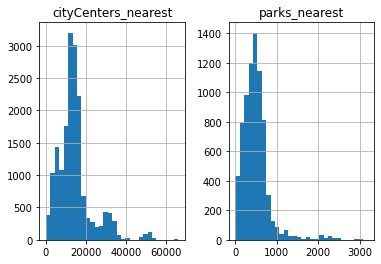

In [50]:
data[['cityCenters_nearest', 'parks_nearest']].hist(bins=30)

In [51]:
mask1_center = ~data['cityCenters_nearest'].isna()
mask2_center = data['cityCenters_nearest'] <= 40000
data[mask1_center] = data[mask2_center]

In [52]:
mask1_parks = ~data['parks_nearest'].isna()
mask2_parks = data['parks_nearest'] <= 2500
data[mask1_parks] = data[mask2_parks]

#### Анализ скорости продажи кватрир

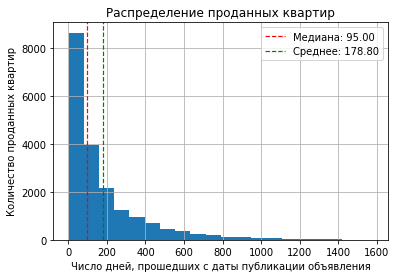

In [53]:
#Вычисляем медианное и среднее значения
median_days_exposition = data['days_exposition'].median()
mean_days_exposition = data['days_exposition'].mean()

#Строим гмтограмму
plt.hist(data['days_exposition'], bins=20)
plt.title('Распределение проданных квартир')
plt.xlabel('Число дней, прошедших с даты публикации объявления')
plt.ylabel('Количество проданных квартир')

#Формируем линии медианного и среднего значений
median_line = plt.axvline(median_days_exposition, color='red', linestyle='dashed', linewidth=1.2)
mean_line = plt.axvline(mean_days_exposition, color='green', linestyle='dashed', linewidth=1.2)

# Получаем существующие элементы гистограммы и добавляем линии медианы и среднего
handles, labels = plt.gca().get_legend_handles_labels() 
handles.append(median_line) 
handles.append(mean_line)
labels.append(f'Медиана: {median_days_exposition:.2f}')
labels.append(f'Среднее: {mean_days_exposition:.2f}')
plt.legend(handles, labels)
plt.grid()
plt.show()

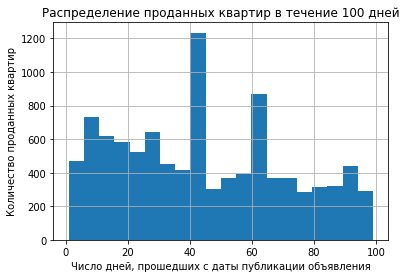

In [54]:
plt.hist(data[data['days_exposition'] < 100]['days_exposition'], bins=20)
plt.title('Распределение проданных квартир в течение 100 дней')
plt.xlabel('Число дней, прошедших с даты публикации объявления')
plt.ylabel('Количество проданных квартир')
plt.grid()
plt.show()

In [55]:
data[(40 < data['days_exposition']) & (data['days_exposition'] < 46)]['last_price'].describe()

count    1.234000e+03
mean     3.670208e+06
std      4.005298e+06
min      4.300000e+05
25%      2.550000e+06
50%      3.450000e+06
75%      4.100000e+06
max      1.240000e+08
Name: last_price, dtype: float64

In [56]:
data[data['days_exposition'] < 40]['last_price'].describe()

count        4356.0
mean      5256816.5
std       4027946.0
min        530000.0
25%       3450000.0
50%       4400000.0
75%       5990000.0
max      95000000.0
Name: last_price, dtype: float64

**Вывод**

Большинство квартир продается в течение 95 дней. Быстрыми можно считать продажи, которые завершаются в течение 200 дней, а аномально долгими продажами можно назвать те, чья длительность составляет более 1.5 года 

В диапазоне от 0 до 100 дней можно обнаружить пики продаж, когда в среднем за 5 дней число проданных кватрир превышало 800. Это связано с тем, что в эти дни медианная цена на недвижимость  достигала минимальных значений по сравнению с другими периодами

#### Выявление факторов, которые больше всего влияют на общую стоимость объекта

In [57]:
data.corr()['last_price']

total_images           0.124349
last_price             1.000000
total_area             0.717175
rooms                  0.421156
ceiling_height         0.364061
floors_total           0.051775
living_area            0.599673
floor                  0.055893
kitchen_area           0.474005
balcony                0.026188
airports_nearest      -0.020367
cityCenters_nearest   -0.325832
parks_around3000       0.287972
parks_nearest         -0.006463
ponds_around3000       0.301742
ponds_nearest         -0.108350
days_exposition        0.114382
price_metr             0.762312
day_of_pub            -0.006247
month_of_pub           0.013913
year_of_pub           -0.051713
cityCenters_km        -0.325837
Name: last_price, dtype: float64

На основании значений коэффициента корреляции можно сделать вывод, что наибольшее влияние на итоговую цену квартиры влияет общая площадь, которую в свою очередь формируют такие параметры как жилая площадь, число комнат и площадь кухни

Изучим другие факторы ценообразования:

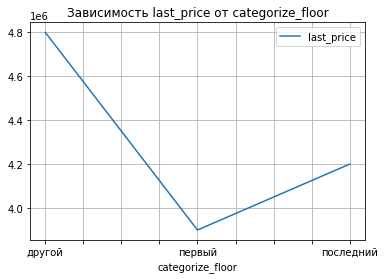

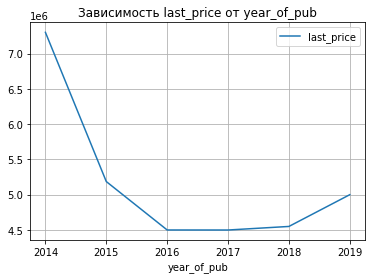

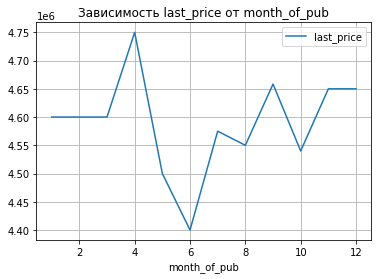

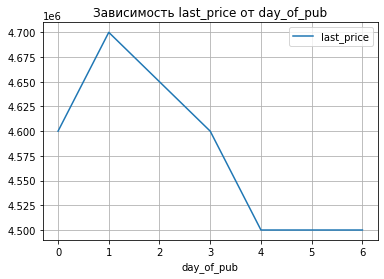

In [58]:
factors = ['categorize_floor', 'year_of_pub', 'month_of_pub', 'day_of_pub']

for fact in factors:
    factor_pivot_table = data.pivot_table(index=fact, values='last_price', aggfunc='median')
    factor_pivot_table =  factor_pivot_table.reset_index()
    factor_pivot_table.plot(x=fact, y='last_price')
    plt.title(f'Зависимость last_price от {fact}')
    plt.grid(True) 
    plt.show()

**Вывод**

Главный фактор, влияющий на ценообразование квартиры - это ее общая площадь, соответственно, чем больше площадь, тем выше цена. Что касается таких факторов как этажность и дата публикации объявления, ситуация следующая:
* Дорогостоящие квартиры располагаются на этажах, находящихся между первым и последним этажами
* В определенные времена года цена на недвижимость снижается (зима, лето ), а весной и сенью, наоборот, возрастает
* В начале недели публикуются объекты по наиболее высокими ценами, а к концу недели можно заметить тренд на снижение цены в объявлениях
* Делать объективные выводы относительно зависимости цены от года публикации объявления проблематично, потому что не удается в достаточной мере проследить тренд ценообразования. Вероятно, следует, рассматривать более длинный промежуток времени 

#### Исследование зависимости цены квадратного метра в популярных населенных пунктах

In [59]:
price_loc_pub = data.pivot_table(index='locality_name', values='first_day_exposition', aggfunc='count')
price_loc_metr = data.pivot_table(index='locality_name', values='price_metr')

res_pub_metr = price_loc_pub.join(price_loc_metr).sort_values(by='first_day_exposition', ascending=False).head(10)
res_pub_metr = res_pub_metr.rename(columns={'first_day_exposition':'number_of_pubs', 'price_metr':'mean_price_metr'})
res_pub_metr = res_pub_metr.sort_values(by='mean_price_metr', ascending=False).reset_index()
res_pub_metr

,locality_name,number_of_pubs,mean_price_metr
0,санкт-петербург,14896,112169.320312
1,пушкин,354,102581.742188
2,деревня кудрово,284,92314.468750
3,поселок парголово,324,90336.007812
4,поселок мурино,525,85310.976562
5,поселок шушары,432,78372.656250
6,колпино,334,75304.585938
7,гатчина,301,68628.546875
8,всеволожск,388,68593.031250
9,выборг,230,57531.191406


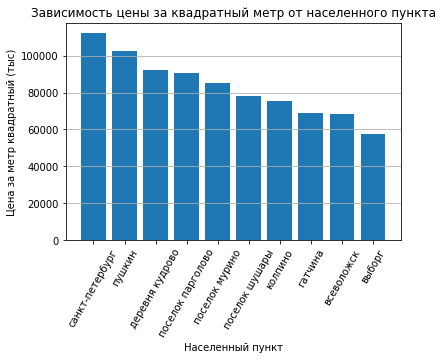

In [60]:
plt.bar(res_pub_metr['locality_name'], res_pub_metr['mean_price_metr'])
plt.title('Зависимость цены за квадратный метр от населенного пункта')
plt.xlabel('Населенный пункт')
plt.ylabel('Цена за метр квадратный (тыс)')
plt.xticks(rotation=60)
plt.grid(axis='y')
plt.show()

**Вывод**

Населёнными пунктами с самой высокой стоимостью квадратного метра являются Санкт-Петербург и Пушкин, а самая низкая стоимость квадратного метра наблюдается в Выборге

#### Зависимость цены квартиры от расстояния до центра города

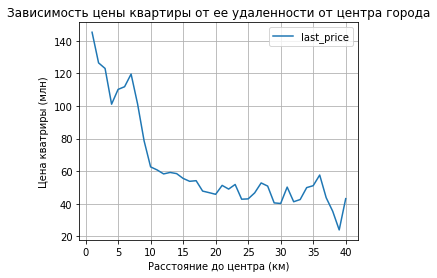

In [61]:
center_price = data[['locality_name', 'last_price']].copy()

#Вычисляем, на каком километре от центра расположена квартира
center_price['distance_center'] = np.where(data['cityCenters_km'].isna(),
                                            np.nan,
                                            np.ceil(data['cityCenters_km']))

#Делим значения last_price для корректного отображения на графике
center_price['last_price'] = center_price['last_price'] / 100000
center_price_pivot = center_price.pivot_table(index='distance_center', values='last_price')

#Строим график зависимости 
pd.options.display.float_format = '{:.0f}'.format
center_price_pivot.plot(figsize=(5, 4))
plt.title('Зависимость цены квартиры от ее удаленности от центра города')
plt.ylabel('Цена кватриры (млн)')
plt.xlabel('Расстояние до центра (км)')
plt.grid(True) 
plt.show()

**Вывод**

Цена квартиры зависит от расстояния до центра города достаточно очевидным образом: чем меньше расстояние до центра, тем выше цена квартиры. С удалением от центра цена уменьшается. Однако в районе 40км и 55км присутствуют объекты, цена которых значительно выше объектов с аналогичной удаленностью

### Общий вывод

Рыночная стоимсоть недвижимости складывается под влиянием многих факторов, в ходе исследования были выявлены наиболее важные косвенные и прямые параметры ценообразования:
* Общая площадь
* Этажность
* Расстояние до центра города
* Сезонность

*Общая площадь*  
Общая площадь - главный прямой и собирательный параметр, от которого зависят не менее важные характеристики такие как жилая площадь, число комнат и площадь кухни. Цена прямопропорциональна площади квартиры 

*Этажность*  
У каждого потенциального покупателя есть потребность в безопасности. Самыми безопасными считаютмя этажи, находящиеся между первым и последним, поэтому высокий спрос и, как следствие, наиболее высокие цены характерны именно для квартир, расположенных на описанных ранее этажах

*Расстояние до центра города*  
Еще одна важная потребность - это потребность в комфорте за пределами квартиры. Эту потребность может удовлетворить развитая инфраструктура района (наличие парков, водоемов и тп), которая зависит от расстояния до центра города. Близость к центру позволяет обеспечивает покупателю доступ к ряду услуг, недоступных для отдаленных уголков Ленинградской области

*Сезонность*  
Весна и осень - самые благоприятные сезоны для роста цен по следующим причинам: чаще всего весной сдают новостройки, а ближе к осени традиционно большинство людей возвращаются из отпусков и возвращаются к решению квартирного вопроса - эти факторы стимилуруют рост спроса и цен соотвественно 